# Embedding's для MovieLens 27M датасета

## Описание задачи

Необходимо построить векторное представление пользователей и фильмов используя нейросетевые подходы, чтобы можно было по эмбендингу пользователя искать похожие эмбендинги фильмов и рекомендовать ему их.

Обратить внимание на:

1. Какие данные на обучение и валидацию, обоснование.
2. Выбор и обоснование метрики
3. Разработка архитектуры нейронной сети с пояснением
4. Обучение и валидация
5. Решение должно быть воспроизводимым с подробными комментариями на каждом шаге

## Описание данных

*Полный* датасет MovieLens с сайта grouplens.org: https://files.grouplens.org/datasets/movielens/ml-latest.zip

В датасете содержится информация о фильмах и оценках пользователей.


**Структура файла данных рейтингов (ratings.csv)**

-----------------------------------------

Все рейтинги содержатся в файле `ratings.csv`. Каждая строка этого файла после строки заголовка представляет собой одну оценку одного фильма одним пользователем и имеет следующий формат:
userId,movieId,rating,timestamp

Строки в этом файле упорядочены сначала по идентификатору пользователя, затем, внутри пользователя, по идентификатору фильма.

Оценки выставляются по 5-звездочной шкале, с шагом в ползвезды (0,5 звезды - 5,0 звезды).

Временные метки представляют собой секунды с полуночи по всемирному координированному времени (UTC) от 1 января 1970 года.


## Анализ данных

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from pylab import rcParams
import matplotlib.pyplot as plt

from keras.layers import Dense , Dot, Dropout, Flatten, Input, Embedding
from keras.optimizers import Adam
from keras.models import Model

from sklearn.metrics import mean_squared_error

import requests
from io import BytesIO
from zipfile import ZipFile

Сделаем превечный осмотр данных

In [2]:
try:
    df = pd.read_csv('ml-latest/ratings.csv')
except:
    path = 'https://files.grouplens.org/datasets/movielens/ml-latest.zip'
    with ZipFile(BytesIO(requests.get(path).content)) as z:
        with z.open('ml-latest/ratings.csv') as f:
            df = pd.read_csv(f)

In [3]:
# make small dataset for testing
# df = df[:100_000]

In [4]:
df.head()

,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27753444 entries, 0 to 27753443
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 847.0 MB


In [6]:
df = df.rename(columns={'userId': 'user_id', 'movieId': 'movie_id'})

In [7]:
rating_pre_user = df.groupby('user_id')['rating'].count()
rating_pre_movie = df.groupby('movie_id')['rating'].count()

print(f'Количество пользователей: {len(rating_pre_user)}')
print(f'Количество фильмов: {len(rating_pre_movie)}')
print()

print(f'Максимальная оценка: {df["rating"].max()}')
print(f'Минимальная оценка: {df["rating"].min()}')
print(f'Медианная оценка: {df["rating"].median()}')
print(f'Количество оценок: {df["rating"].count()}')
print()

print(f'Максимальное количество оценок на пользователя: {rating_pre_user.max()}')
print(f'Минимальное количество оценок на пользователя: {rating_pre_user.min()}')
print(f'Медианное количество оценок на пользователя: {rating_pre_user.median()}')
print()

print(f'Максимальное количество оценок на фильм: {rating_pre_movie.max()}')
print(f'Минимальное количество оценок на фильм: {rating_pre_movie.min()}')
print(f'Медианное количество оценок на фильм: {rating_pre_movie.median()}')

del rating_pre_user, rating_pre_movie

Количество пользователей: 283228
Количество фильмов: 53889

Максимальная оценка: 5.0
Минимальная оценка: 0.5
Медианная оценка: 3.5
Количество оценок: 27753444

Максимальное количество оценок на пользователя: 23715
Минимальное количество оценок на пользователя: 1
Медианное количество оценок на пользователя: 30.0

Максимальное количество оценок на фильм: 97999
Минимальное количество оценок на фильм: 1
Медианное количество оценок на фильм: 7.0


Данный вывод дает основное представление о данных. Все кажется отличным, кроме id фильмов. Он не имеет такого же порядка, как у id пользователя. Нужно будет при обучении создавать собственный словарь для id, чтобы не было проблем с размерностью.

In [8]:
print(f'Максимальный ID пользователя: {df["user_id"].max()}')
print(f'Минимальный ID пользователя: {df["user_id"].min()} \n')

print(f'Максимальный ID фильма: {df["movie_id"].max()}')
print(f'Минимальный ID фильма: {df["movie_id"].min()} \n')

print(f'Кол-во уникальных ID пользователей: {df["user_id"].nunique()}')
print(f'Кол-во уникальных ID фильмов: {df["movie_id"].nunique()}')

Максимальный ID пользователя: 283228
Минимальный ID пользователя: 1 

Максимальный ID фильма: 193886
Минимальный ID фильма: 1 

Кол-во уникальных ID пользователей: 283228
Кол-во уникальных ID фильмов: 53889


Данный вывод, так же, подтверждает необходимость создания собственного словаря для id.

In [9]:
df.isna().sum()

user_id      0
movie_id     0
rating       0
timestamp    0
dtype: int64

In [10]:
df.duplicated().sum()

0

В данных не обнаружено пропусков и дубликатов. Можно приступать к подготовке данных.

## Подготовка данных

In [11]:
df['user_id'] = df['user_id'].astype('category').cat.codes.values
df['movie_id'] = df['movie_id'].astype('category').cat.codes.values

In [12]:
df['user_id'].value_counts(ascending=True).head()

user_id
47251     1
5366      1
5364      1
32981     1
150426    1
Name: count, dtype: int64

In [13]:
users = df['user_id'].unique()
movies = df['movie_id'].unique()

userid2idx = {o:i for i,o in enumerate(users)}
movieid2idx = {o:i for i,o in enumerate(movies)}

df['user_id'] = df['user_id'].apply(lambda x: userid2idx[x])
df['movie_id'] = df['movie_id'].apply(lambda x: movieid2idx[x])

Как я и говорил, создадим собственный словарь для id и перезапишем id в датасете. Так мы можем быть уверены, что размерность данных будет соответствовать размерности векторов.

Нужно произвести разделение данных на обучающую и тестовую выборки. Для этого воспользуемся функцией из статьи [Сравнение матричной факторизации с трансформерами на наборе данных MovieLens с применением библиотеки pytorch-acceleratd](https://habr.com/ru/companies/wunderfund/articles/645921/).

Данные функции не позволят допустить утечки данных в тестовую выборку. И оценка качества модели будет более объективной.

In [14]:
def get_last_n_ratings_by_user(
        df, n, min_ratings_per_user=1, user_colname="user_id", timestamp_colname="timestamp"
):
    return (
        df.groupby(user_colname)
        .filter(lambda x: len(x) >= min_ratings_per_user)
        .sort_values(timestamp_colname)
        .groupby(user_colname)
        .tail(n)
        .sort_values(user_colname)
    )

In [15]:
def mark_last_n_ratings_as_validation_set(
        df, n, min_ratings=1, user_colname="user_id", timestamp_colname="timestamp"
):
    """
    Отмечает n последних по времени оценок, что включает их в проверочную выборку.
    Делается это путём добавления дополнительного столбца 'is_valid' в df.
    :param df: объект DataFrame, содержащий оценки, данные пользователем
    :param n: количество оценок, которые надо включить в проверочную выборку
    :param min_ratings: включать лишь пользователей, имеющих более этого количества оценок
    :param user_id_colname: имя столбца, содержащего идентификатор пользователя
    :param timestamp_colname: имя столбца, содержащего отметку времени
    :return: тот же df, в который добавлен дополнительный столбец 'is_valid'
    """
    df["is_valid"] = False
    df.loc[
        get_last_n_ratings_by_user(
            df,
            n,
            min_ratings,
            user_colname=user_colname,
            timestamp_colname=timestamp_colname,
        ).index,
        "is_valid",
    ] = True
    return df

In [16]:
mark_last_n_ratings_as_validation_set(df, n=10, min_ratings=10);

In [17]:
train_df = df[df['is_valid'] == False].drop(columns=['is_valid'])
test_df = df[df['is_valid'] == True].drop(columns=['is_valid'])

Применяем функции для разделения данных на обучающую и тестовую выборки. Мы берем 10 последних оценок пользователя у которого оценено больше 10 фильмов и помечаем их как тестовые. И на основе этих пометок создаем два датасета `train_df` и `test_df`.

In [18]:
# show ratio of train and test data
print(f'Количество строк в тренировочном датасете: {len(train_df)}')
print(f'Количество строк в тестовом датасете: {len(test_df)}')
print(f'{len(df) / len(test_df):.2f}% тестового датасета')

Количество строк в тренировочном датасете: 25316864
Количество строк в тестовом датасете: 2436580
11.39% тестового датасета


Примерное соотношение 90:10. Почти, 10% данных будет достаточно для тестирования модели. Произведем разделение данных на обучающую и валидационную выборки, по такому же принципу.

In [19]:
df_train = mark_last_n_ratings_as_validation_set(train_df, n=5, min_ratings=5)

In [20]:
train = df_train[df_train['is_valid'] == False].drop(columns=['is_valid'])
valid = df_train[df_train['is_valid'] == True].drop(columns=['is_valid'])

del df_train

In [21]:
# show ratio of train and test data
print(f'Количество строк в тренировочном датасете: {len(train)}')
print(f'Количество строк в проверочном датасете: {len(valid)}')
print(f'{len(train_df) / len(valid):.2f}% тестового датасета')

Количество строк в тренировочном датасете: 24090579
Количество строк в проверочном датасете: 1226285
20.65% тестового датасета


Примерное соотношение 80:20. Почти, 20% данных будет достаточно для валидации модели. Можно переходить к обучению моделей.

In [22]:
del train_df

In [23]:
train.head()

,user_id,movie_id,rating,timestamp
14,0,14,2.0,1256677210
41,2,41,4.0,945141407
42,3,42,4.0,1113765937
43,3,43,4.0,1113767306
44,3,44,2.0,1123990453


## Построение модели


Модель:
- Будем использовать стандартный подход создания эмбеддингов для `users` и `items` - Low Rank Matrix Factorization. Но мы так же добавим прореживание и один слой с 96 нейронами. На выходе будет один нейрон, который будет выдавать оценку фильма. В обоих слоях будем использовать `relu` функцию активации.

Метрика:
- Для обучения модели была выбрана метрика `MSE` (Mean Squared Error). MSE обычно используется в рекомендательных системах на основе матричной факторизации, поскольку он является гладким, дифференцируемым, хорошо понятным и может быть оптимизирован с помощью градиентных методов. Он также эффективен для предотвращения чрезмерной подгонки и может быть настроен для достижения хорошей производительности.

In [24]:
n_movies = len(df['movie_id'].unique())
n_users = len(df['user_id'].unique())

n_latent_factors = 50
dropout_rate = 0.4

In [25]:
user_input = Input(shape=(1,), name='user_input', dtype='int64')
user_embedding = Embedding(n_users, n_latent_factors, name='user_embedding')(user_input)
user_vec = Flatten(name='FlattenUsers')(user_embedding)
user_vec = Dropout(dropout_rate)(user_vec)

In [26]:
movie_input = Input(shape=(1,), name='movie_input', dtype='int64')
movie_embedding = Embedding(n_movies, n_latent_factors, name='movie_embedding')(movie_input)
movie_vec = Flatten(name='FlattenMovies')(movie_embedding)
movie_vec = Dropout(dropout_rate)(movie_vec)

In [27]:
sim = Dot(name='Similarity', axes=1)([user_vec, movie_vec])

In [28]:
nn_inp = Dense(96, activation='relu')(sim)
nn_inp = Dropout(dropout_rate)(nn_inp)
nn_inp = Dense(1, activation='relu')(nn_inp)
nn_model = Model([user_input, movie_input], nn_inp)
nn_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 movie_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 50)        14161400    ['user_input[0][0]']             
                                                                                                  
 movie_embedding (Embedding)    (None, 1, 50)        2694450     ['movie_input[0][0]']            
                                                                                              

Как и писалось выше, создаем модель, используя keras. В качестве входных данных будут `user_id` и `movie_id`. Для каждого из них создаем эмбеддинги с `latent factors` 50. Далее применяем `Dropout` для регуляризации. Далее применяем `Dot` для получения скалярного произведения эмбеддингов. Далее применяем `Dense` слой с 96 нейронами и функцией активации `relu`. Далее применяем `Dropout` для регуляризации. Далее применяем `Dense` слой с 1 нейроном и функцией активации `relu`. И выводим модель на экран. Все создалось успешно. Можно компилировать модель. Будем использовать оптимизатор `Adam` с `learning rate` 0.001 и функцию потерь `mse`.

In [29]:
nn_model.compile(optimizer=Adam(lr=1e-3), loss='mse')

Для обучения возьмем `batch_size` 20 000 и `epochs` 5. Этого будет достаточно, что дойти до приемлемого результата. Не затрачивая много времени.

In [30]:
batch_size = 20_000
epochs = 5

In [31]:
history = nn_model.fit(
    x=[train['user_id'], train['movie_id']],
    y=train['rating'],
    batch_size=batch_size,
    epochs=epochs,
    validation_data=([valid['user_id'], valid['movie_id']], valid['rating']),
    verbose=1
)

Epoch 1/5
1205/1205 [==============================] - 243s 199ms/step - loss: 2.0879 - val_loss: 1.0431
Epoch 2/5
1205/1205 [==============================] - 240s 199ms/step - loss: 0.8947 - val_loss: 0.9692
Epoch 3/5
1205/1205 [==============================] - 238s 198ms/step - loss: 0.8308 - val_loss: 0.9428
Epoch 4/5
1205/1205 [==============================] - 238s 197ms/step - loss: 0.7942 - val_loss: 0.9282
Epoch 5/5
1205/1205 [==============================] - 239s 198ms/step - loss: 0.7575 - val_loss: 0.9203


## Анализ модели

Построим графики обучения модели. Чтобы отследить переобучение модели.

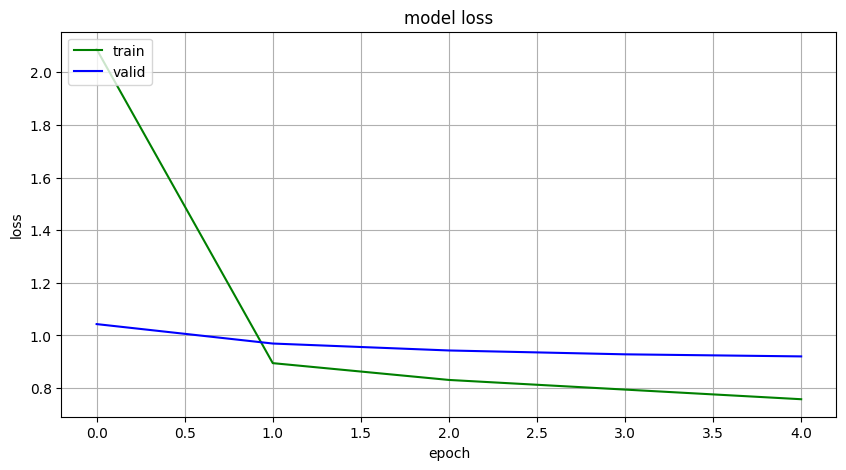

In [32]:
rcParams['figure.figsize'] = 10, 5

plt.plot(history.history['loss'] , 'g')
plt.plot(history.history['val_loss'] , 'b')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.grid(True)
plt.show()

Помимо этого, проверим модель на тестовых данных. И после сравним с константной моделью.

In [33]:
# evaluate model
nn_model.evaluate(x=[test_df['user_id'], test_df['movie_id']], y=test_df['rating'])

76144/76144 [==============================] - 88s 1ms/step - loss: 0.9448


0.9447519779205322

In [35]:
# constant model
constant_model = np.full_like(test_df['rating'], train['rating'].mean())

print(f'Constant model MSE: {mean_squared_error(test_df["rating"], constant_model)}')

Constant model MSE: 1.2132921589921126


Мы можем наблюдать, что модель практически не переобучена и показывает хороший результат на тестовых данных. Помимо этого, она показывает лучший результат, чем константная модель. Можно сказать, что обучение прошло успешно. Но есть что улучшить (об этом написано в выводе).

In [36]:
# save model
nn_model.save('models/nn_model_17M_10-05-2023.h5')

## Создание рекомендаций на основе эмбеддингов

Достанем веса из обученной модели. Запишем веса эмбеддингов пользователей и фильмов в отдельные переменные.

In [37]:
user_embeddings = nn_model.get_layer('user_embedding').get_weights()[0]
movie_embeddings = nn_model.get_layer('movie_embedding').get_weights()[0]

Сохраним эмбеддинги в файлы. Чтобы потом их можно было использовать без необходимости обучать модель заново.

In [38]:
# save embeddings
np.save('embeddings/user_embeddings.npy', user_embeddings)
np.save('embeddings/movie_embeddings.npy', movie_embeddings)

In [39]:
# load embeddings
# user_embeddings = np.load('embeddings/user_embeddings.npy')
# movie_embeddings = np.load('embeddings/movie_embeddings.npy')

Реализуем простой пример, как можно применить эмбеддинги для рекомендаций. Для этого возьмем `user_id` пользователя . Достанем его эмбеддинг. Нормализуем эмбеддинги фильмов. Посчитаем скалярное произведение эмбеддинга пользователя и эмбеддингов фильмов. И выберем топ 10 фильмов с наибольшими значениями скалярного произведения.

In [40]:
# define function to make recommendations
def make_recommendations(user_id: int, n_movies: int = 10) -> np.ndarray:
    """
    Make movie recommendations for user_id
    :param user_id: id of user to make recommendations. Starts at 1 (user_id - 1)
    :param n_movies: count of movies to recommend. Default 10
    :return: top n_movies ids
    """
    user_embedding = user_embeddings[user_id-1]

    movie_embeddings_norm = movie_embeddings / np.linalg.norm(movie_embeddings, axis = 1).reshape((-1, 1))
    scores = user_embedding.dot(movie_embeddings_norm.T)

    top_movies = np.argpartition(scores, -n_movies)[-n_movies:]

    return top_movies

In [43]:
user_id = 1
top_movies = make_recommendations(user_id)
print(f'Top 10 movies for user {user_id}:')
print(top_movies)

Top 10 movies for user 1:
[16079  3634 24780  3171     6 25947  1945  6461  3246  4504]


Данную рекомендацию можно использовать и предлагать пользователям. Но, чтобы сделать ее более интересной, можно добавить фильтрацию по жанрам, годам, рейтингу и т.д.

### Создание эмбеддингов для новых пользователей

In [44]:
# make embeddings for new user
new_user = {'user_id': [138494], 'movie_id': [1], 'rating': [5]}
new_user = pd.DataFrame(new_user)

new_user_embedding = nn_model.predict([new_user['user_id'], new_user['movie_id']])

1/1 [==============================] - 0s 131ms/step


Сверху переведен код того, как можно добавлять новых пользователей в систему. Но в данном случае, мы не будем добавлять новых пользователей. Поэтому, просто продемонстрируем, как можно получить эмбеддинги для новых пользователей.

## Вывод

В ходе выполнения данного проекта были реализованы следующие задачи:
- **Подготовка данных**
- - Загрузка данных
- - Проверка на пропуски и дубликаты
- - Разделение данных на train, valid, test учитывая временную зависимость

|

- **Создание модели**
- - Создание модели Low Rank Matrix Factorization c NN
- - Обучение модели с помощью Adam optimizer и MSE loss. Прогресс был сохранен в переменную history

|

- **Анализ модели**
- - Построение графика обучения модели
- - Проверка модели на тестовых данных
- - Создание константной модели
- - Сравнение моделей
- - Сохранение модели в файл

|

- **Создание рекомендаций на основе эмбеддингов**
- - Получения эмбеддингов из обученной модели, по способу получения весов слоя
- - Сохранение эмбеддингов в файлы
- - Создание функции для рекомендаций фильмов для пользователя. Для этого используется скалярное произведение эмбеддинга пользователя и эмбеддингов фильмов.

|

- **Создание эмбеддингов для новых пользователей**
- - Создание нового пользователя
- - Получение эмбеддинга нового пользователя с помощью обученной модели



**Что можно улучшить:**
- Модель обучается долго на CPU. Можно было использовать GPU для ускорения обучения.
- Можно увеличить количество эпох обучения и уменьшить кол-во батчей, чтобы улучшить качество модели. На данный момент этого не было сделано из-за недостатка времени. На мой взгляд, данную модель с этими данными, можно довести минимум до 0.5 MSE на тестовых данных. То есть, модель будет ошибаться в 0.25 единиц рейтинга.
- После проверки адекватности модели, можно дообучить ее на валидационных данных, чтобы улучшить качество модели.